In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("youtube_trending_videos_global.csv")

/var/folders/k9/62mpfz413bxfg1_cth95xn5c0000gn/T/ipykernel_72921/1344914435.py:1: DtypeWarning: Columns (13,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("youtube_trending_videos_global.csv")


In [3]:
# Fill NA text fields with 'NA'
df['video_description'] = df['video_description'].fillna('NA')
df['video_tags'] = df['video_tags'].fillna('NA')
df['video_title'] = df['video_title'].fillna('Untitled')

# Fill NA numeric fields with median
for col in ['video_view_count', 'video_like_count', 'video_comment_count']:
    df[col] = df[col].fillna(df[col].median())

In [4]:
# 🔧 3. FEATURE ENGINEERING (ADVANCED)
# ==========================
# Duration as numeric estimate
df['video_duration_sec'] = df['video_duration'].str.extract(r'(\d+)').fillna(0).astype(int)

# Tag count
df['video_tag_count'] = df['video_tags'].str.count('\|') + 1

# Sentiment scores
analyzer = SentimentIntensityAnalyzer()
df['title_sentiment'] = df['video_title'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df['desc_sentiment'] = df['video_description'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# Engagement ratios
df['like_view_ratio'] = df['video_like_count'] / (df['video_view_count'] + 1)
df['comment_view_ratio'] = df['video_comment_count'] / (df['video_view_count'] + 1)

# Binary target: Is video more popular than average?
mean_views = df['video_view_count'].mean()
df['is_popular'] = (df['video_view_count'] > mean_views).astype(int)

In [5]:
# 🧠 4. MODEL TRAINING (BOOSTED + SCALED)
# ==========================
features = [
    'video_duration_sec', 'video_tag_count',
    'video_like_count', 'video_comment_count',
    'like_view_ratio', 'comment_view_ratio',
    'title_sentiment', 'desc_sentiment'
]

X = df[features]
y = df['is_popular']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    316034
           1       0.99      0.99      0.99     95577

    accuracy                           1.00    411611
   macro avg       1.00      1.00      1.00    411611
weighted avg       1.00      1.00      1.00    411611



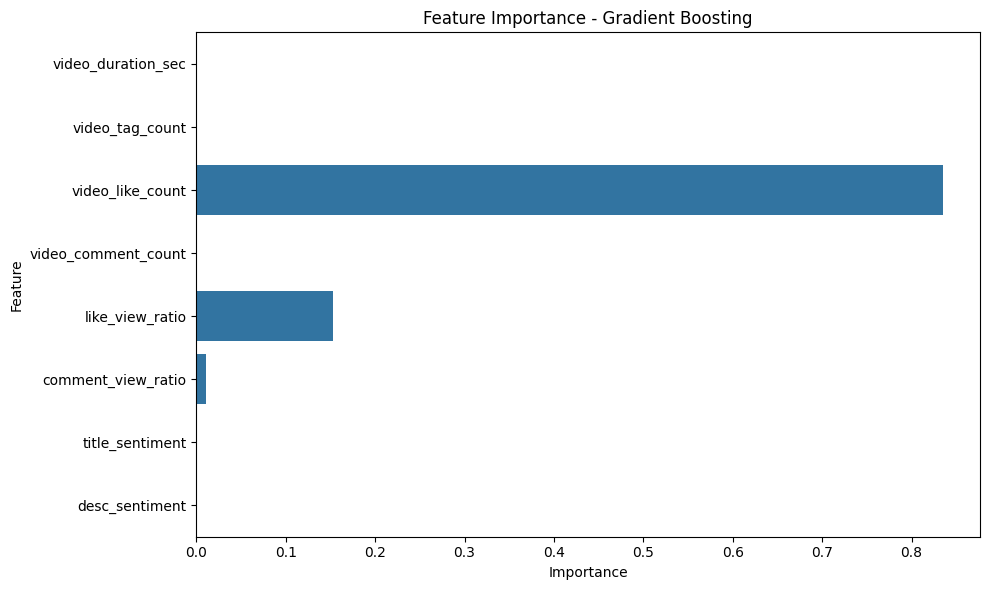

In [6]:
# 📊 5. VISUALIZE FEATURE IMPORTANCE
# ==========================
plt.figure(figsize=(10, 6))
sns.barplot(x=model.feature_importances_, y=features)
plt.title("Feature Importance - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

/var/folders/k9/62mpfz413bxfg1_cth95xn5c0000gn/T/ipykernel_72921/1027353854.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


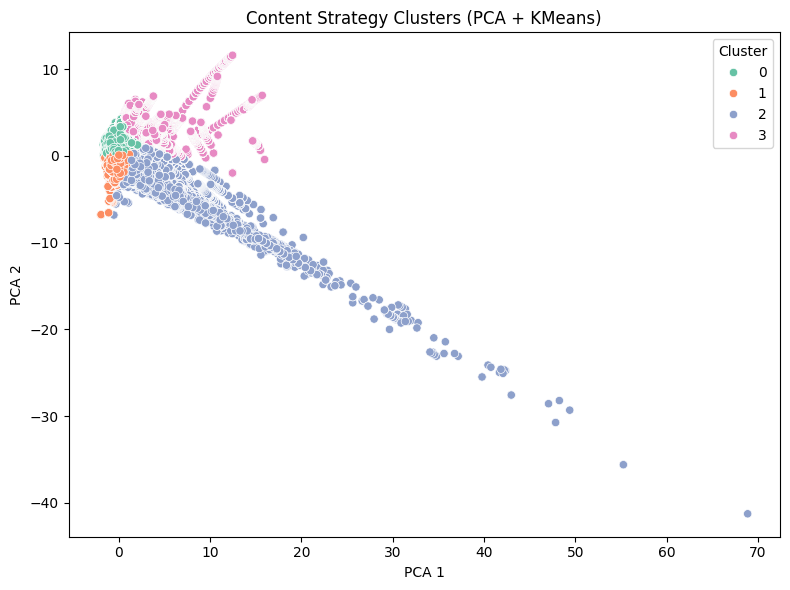

In [7]:
# 🔍 6. CONTENT STRATEGY CLUSTERING (PCA + KMeans Ready)
# ==========================
# Reduce dimensionality for clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['content_cluster'] = kmeans.fit_predict(X_pca)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['content_cluster'], palette='Set2')
plt.title("Content Strategy Clusters (PCA + KMeans)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [8]:
 # Cluster summary
cluster_summary = df.groupby('content_cluster')[features].mean()
print("\n📊 Cluster-Based Content Strategy Averages:\n")
print(cluster_summary.round(2))


📊 Cluster-Based Content Strategy Averages:

                 video_duration_sec  video_tag_count  video_like_count  \
content_cluster                                                          
0                             28.07             1.00         746136.01   
1                             15.51             1.01         113571.66   
2                             11.50             1.01         229648.93   
3                             15.19             1.00        3644924.82   

                 video_comment_count  like_view_ratio  comment_view_ratio  \
content_cluster                                                             
0                            4370.37             0.03                0.00   
1                            3185.47             0.04                0.00   
2                           22477.68             0.10                0.01   
3                          111550.49             0.05                0.00   

                 title_sentiment  desc_sentimen

In [11]:
# 🧭 7. STRATEGY RECOMMENDER ENGINE (MATCH PCA SPACE)
# ==========================

def recommend_strategy(row_df, pca_model, kmeans_model, scaler_model):
    # Scale input features
    scaled = scaler_model.transform(row_df)
    # Reduce to PCA space
    reduced = pca_model.transform(scaled)
    # Predict closest cluster
    return kmeans_model.predict(reduced)[0]

# Recommend content strategy cluster for a sample video
sample_video_df = pd.DataFrame([X.iloc[0]], columns=features)
recommended_cluster = recommend_strategy(sample_video_df, pca, kmeans, scaler)

print("\n🎯 Recommended Content Strategy Cluster:", recommended_cluster)
print("🔍 Characteristics:")
print(cluster_summary.loc[recommended_cluster].round(2))



🎯 Recommended Content Strategy Cluster: 3
🔍 Characteristics:
video_duration_sec          15.19
video_tag_count              1.00
video_like_count       3644924.82
video_comment_count     111550.49
like_view_ratio              0.05
comment_view_ratio           0.00
title_sentiment              0.10
desc_sentiment               0.53
Name: 3, dtype: float64
